In [2]:
from neural_network import * 
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import rcParams
%matplotlib inline
import pickle
import seaborn as sns

logdust_func = open("logdust_3d_func.pkl", "rb")
logstdA_func = open("logstdA_func.pkl", "rb")
logdust = pickle.load(logdust_func)
logstdA = pickle.load(logstdA_func)

2022-10-18 11:51:12.209675: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-18 11:51:12.820075: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-18 11:51:12.820102: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-18 11:51:12.901360: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-18 11:51:14.623300: W tensorflow/stream_executor/platform/de

In [3]:
# rcParams.update({'xtick.major.pad': '7.0'})
# rcParams.update({'xtick.major.size': '7.5'})
# rcParams.update({'xtick.major.width': '1.5'})
# rcParams.update({'xtick.minor.pad': '7.0'})
# rcParams.update({'xtick.minor.size': '3.5'})
# rcParams.update({'xtick.minor.width': '1.0'})
# rcParams.update({'ytick.major.pad': '7.0'})
# rcParams.update({'ytick.major.size': '7.5'})
# rcParams.update({'ytick.major.width': '1.5'})
# rcParams.update({'ytick.minor.pad': '7.0'})
# rcParams.update({'ytick.minor.size': '3.5'})
# rcParams.update({'ytick.minor.width': '1.0'})
# rcParams.update({'axes.titlepad': '15.0'})
# rcParams.update({'axes.labelpad': '15.0'})
rcParams.update({'font.size': 20})
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=r'\usepackage{amsmath}'

In [19]:
samp_size = 5
def get_NN_pred_mean(model, X_data):
    '''Return (A_mean, A_std) prediction given list of (x, y, z)'''
    # X_data_flattened = X_data.reshape([len(X_data) * samp_size, 3])
    pred = model(X_data, training=False) # (len(X_data) * SAMPLE_SIZE, 3)
    pred_np = pred.numpy()
    pred_np = tf.reshape(pred_np, pred_np.shape[0])
    return pred_np

def get_NN_pred_mean2(model, X_data):
    '''Return (A_mean, A_std) prediction given list of (x, y, z)'''
    # X_data_flattened = X_data.reshape([len(X_data) * samp_size, 3])
    pred = model(X_data, training=False) # (len(X_data) * SAMPLE_SIZE, 3)
    pred_np = pred.numpy()
    pred_np = tf.reshape(pred_np, pred_np.shape[0])
    return pred_np

def get_NN_pred_std(model_A, model_std, X_data):
    '''Return (A_mean, A_std) prediction given list of (x, y, z)'''
    X_data_flattened = X_data.reshape([len(X_data) * samp_size, 3])
    pred_mean = model_A(X_data_flattened, training=False) # (len(X_data) * SAMPLE_SIZE, 3)
    pred_mean = (pred_mean.numpy() - 0.111) * 1/1.22

    # UGLY not best way to do this but np.append didn't work
    inp = []
    for i,x in enumerate(X_data_flattened):
      single_inp = [xa for xa in x] + list(pred_mean[i])
      inp.append(single_inp)
    
    inp = np.asarray(inp)
    print(inp.shape)
    pred_std = model_std(np.asarray(inp), training=False)
    pred_std = tf.reshape(pred_std, pred_std.shape[0])
    # pred_np = pred_np.reshape([len(X_data), SAMPLE_SIZE])
    return pred_std

In [5]:
# load each model
modelA_mean = tf.keras.models.load_model('models/modelA/modelA_mean')
modelB_mean = tf.keras.models.load_model('models/modelB/modelB_mean')
modelC_mean = tf.keras.models.load_model('models/modelC/modelC_mean')
modelD_mean = tf.keras.models.load_model('models/modelD/modelD_mean')
modelD_std = tf.keras.models.load_model('models/modelD/modelD_std')

In [47]:
# data = np.load('datasets/dust_sim_2022.npz', allow_pickle=True)
# Xgrid, Ygrid_samps = data['Xgrid'], data['Ygrid_samps']
# Ygrid_true_attenuation = data['Ygrid_true_attenuation']
# Xo_train, Xo_train, Xo_test = data['Xo_train'], data['Xo_valid'], data['Xo_test']
# Yo_train, Yo_train, Yo_test = data['Yo_train'], data['Yo_valid'], data['Yo_test']


data = np.load('datasets/dust_sim_final.npz', allow_pickle=True)
# Xgrid, Ygrid_samps = data['Xgrid'], data['Ygrid_samps']
# Ygrid_true_attenuation = data['Ygrid_true_attenuation']
X_train, X_train, X_test = data['Xo_train'], data['Xo_valid'], data['Xo_test']
# Yo_train, Yo_train, Yo_test = data['Yo_train'], data['Yo_valid'], data['Yo_test']
Y_train, Y_train, Y_test = data['Y_train'], data['Y_valid'], data['Y_test']

# print(Xo_train[:,0].shape)
# print(Yo_train[:,0].shape)
# print(Y_train[:,0].shape)

In [48]:
# TODO: this is inconsistent - just loop through X_test values not the whole Xgrid
intrinsic = [np.exp(logdust(x,y,z)) for x,y,z in X_test[:,0]]
intrinsic_std = [np.exp(logstdA(x,y,z)) for x,y,z in X_test[:,0]]

def get_underlying_dust(model_mean, X):
    # getting rho
    dA_dx, dA_dy, dA_dz = [], [], []
    norm = model_mean.get_layer('norm')
    dense_1 = model_mean.get_layer('dense_1')
    dense_2 = model_mean.get_layer('dense_2')
    dense_3 = model_mean.get_layer('dense_3')
    pred = model_mean.get_layer('predictions')

    for x,y,z in X:
        xyz = tf.constant([x, y, z])
        with tf.GradientTape() as g:
            g.watch(xyz)
            Y = pred(dense_3(dense_2(dense_1(norm(tf.convert_to_tensor([xyz]))))))
        dA_dxyz = g.gradient(Y, xyz)
        dA_dx.append(dA_dxyz[0])
        dA_dy.append(dA_dxyz[1])
        dA_dz.append(dA_dxyz[2])

    r = np.sqrt(np.square(X[:, 0]) + np.square(X[:, 1]) + np.square(X[:, 2]))
    x = X[:, 0]
    y = X[:, 1]
    z = X[:, 2]
    x_over_r = np.divide(x, r)
    y_over_r = np.divide(y, r)
    z_over_r = np.divide(z, r)
    dA_dr = np.multiply(dA_dx, x_over_r) + np.multiply(dA_dy, y_over_r) + np.multiply(dA_dz, z_over_r)
    return dA_dr

In [49]:
pred_A_modelA = modelA_mean(X_test[:, 0])
dA_dr_modelA = get_underlying_dust(modelA_mean, X_test[:,0])

In [50]:
pred_A_modelB = modelB_mean(X_test[:, 0])
dA_dr_modelB = get_underlying_dust(modelB_mean, X_test[:, 0])

In [51]:
pred_A_modelC = modelC_mean(X_test[:, 0])
dA_dr_modelC = get_underlying_dust(modelC_mean, X_test[:, 0])

In [52]:
pred_A_modelD = modelD_mean(X_test[:, 0])
dA_dr_modelD = get_underlying_dust(modelD_mean, X_test[:, 0])

In [53]:
pred_mean = get_NN_pred_mean(modelD_mean, X_test[:, 0])
pred_mean = np.reshape(pred_mean, (pred_mean.shape[0], 1))
model_std_inps = np.append(X_test[:, 0], pred_mean, axis=1)

pred_std_modelD = get_std_model_pred(modelD_std, model_std_inps, np.log(0.13410718414757786), training=False)
pred_std_modelD = np.reshape(pred_std_modelD, np.shape(pred_std_modelD)[0])
pred_std_modelD = np.exp(pred_std_modelD)

In [54]:
# some reshaping 
num_data = X_test[:,0].shape[0]
pred_A_modelA = np.reshape(pred_A_modelA, num_data)
pred_A_modelB = np.reshape(pred_A_modelB, num_data)
pred_A_modelC = np.reshape(pred_A_modelC, num_data)
pred_A_modelD = np.reshape(pred_A_modelD, num_data)
pred_std_modelD = np.reshape(pred_std_modelD, pred_std_modelD.shape[0])
modelC_final_variable_std = 0.12374137631361162
modelC_final_variable_std_repeated = np.array([modelC_final_variable_std] * num_data)
point2_repeated = np.array([0.2] * num_data)

**Model A:** MSE. Need to train on random samples

**Model B:** fixed scatter, fixed outlier. Need to re-train with different sigma_A value.

**Model C:** variable scatter, variable outlier. Good!

**Model D:** spatially variable scatter, variable outlier. Need to re-train so everything varies together.

/home/ava/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ava/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ava/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ava/.local/lib/pyth

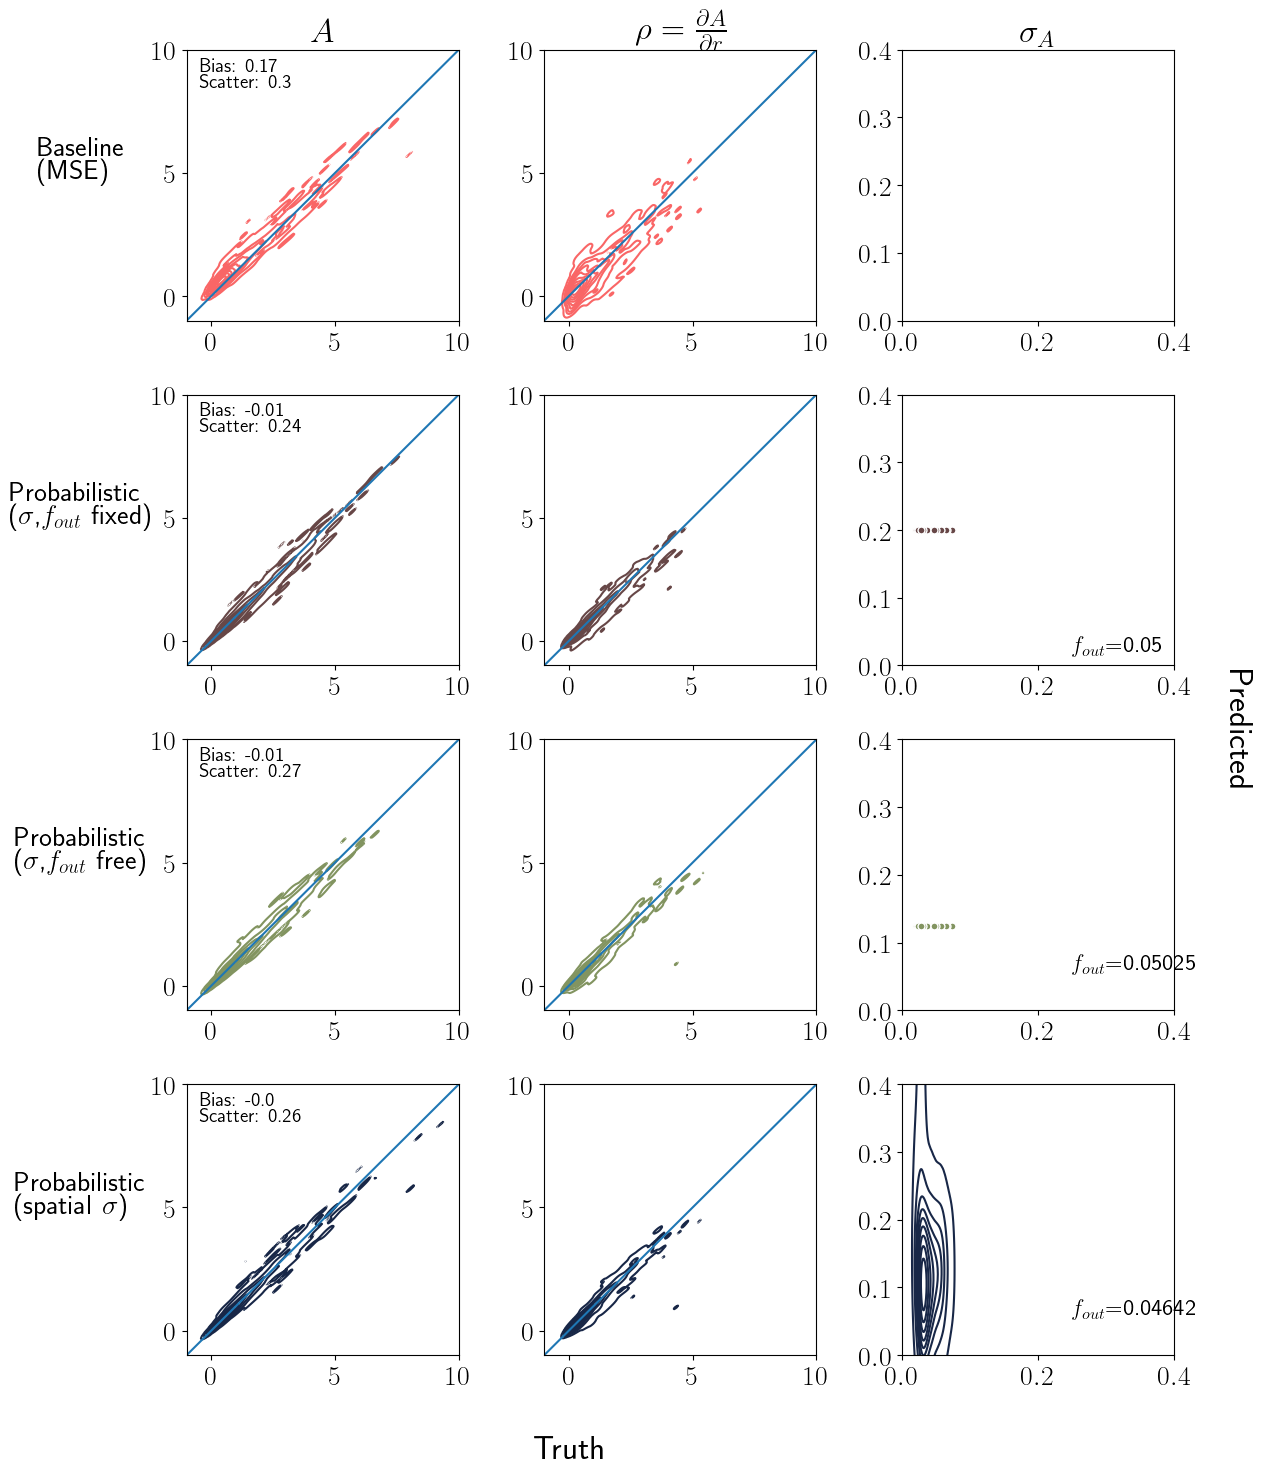

In [56]:
fig = plt.figure(figsize=(13, 15), tight_layout=True)
lims, std_lims = [-1, 10], [0, 0.4]
color1, color2, color3, color4 = "#F96666", "#674747", "#829460", "#182747" # TODO: replace with these colors
fig.supxlabel('Truth')
fig.supylabel('Predicted', ha="right", x=1.025, rotation=270)
# pred_asinh = np.arcsinh(pred_A)
# Y_test_asinh = np.arcsinh(Y_test[:, 0])

plt.subplot(4, 3, 1)
plt.title(r'$A$')
sns.kdeplot(Y_test[:, 0], pred_A_modelA, color=color1, bw_adjust=0.5) 
plt.ylabel("Baseline\n(MSE)", rotation='horizontal', labelpad=50)
residual = pred_A_modelA - Y_test[:, 0]
bias=np.mean(residual)
scatter=np.std(residual)
plt.text(-0.5, 8.5, 'Bias: ' + str(round(bias, 2)) + '\nScatter: ' + str(round(scatter, 2)) , fontsize='x-small')
plt.xlim(lims)
plt.ylim(lims)
plt.plot(lims, lims)

plt.subplot(4, 3, 4)
sns.kdeplot(Y_test[:, 0], pred_A_modelB, color=color2, bw_adjust=0.5)
plt.ylabel("Probabilistic\n("+r'$\sigma$'+","+r'$f_{out}$'+" fixed)", rotation='horizontal', labelpad=50)
residual = pred_A_modelB - Y_test[:, 0]
bias=np.mean(residual)
scatter=np.std(residual)
plt.text(-0.5, 8.5, 'Bias: ' + str(round(bias, 2)) + '\nScatter: ' + str(round(scatter, 2)) , fontsize='x-small')
plt.xlim(lims)
plt.ylim(lims)
plt.plot(lims, lims)

plt.subplot(4, 3, 7)
plt.ylabel("Probabilistic\n("+r'$\sigma$'+","+r'$f_{out}$'+" free)", rotation='horizontal', labelpad=50)
residual = pred_A_modelC - Y_test[:, 0]
bias=np.mean(residual)
scatter=np.std(residual)
plt.text(-0.5, 8.5, 'Bias: ' + str(round(bias, 2)) + '\nScatter: ' + str(round(scatter, 2)) , fontsize='x-small')
sns.kdeplot(Y_test[:, 0], pred_A_modelC, color=color3, bw_adjust=0.5)  
plt.xlim(lims)
plt.ylim(lims)
plt.plot(lims, lims)

plt.subplot(4, 3, 10)
plt.ylabel("Probabilistic\n(spatial "+r'$\sigma$'+")", rotation='horizontal', labelpad=50)
residual = pred_A_modelD - Y_test[:, 0]
bias=np.mean(residual)
scatter=np.std(residual)
plt.text(-0.5, 8.5, 'Bias: ' + str(round(bias, 2)) + '\nScatter: ' + str(round(scatter, 2)) , fontsize='x-small')
sns.kdeplot(Y_test[:, 0], pred_A_modelD, color=color4, bw_adjust=0.5)  
plt.xlim(lims)
plt.ylim(lims)
plt.plot(lims, lims)


# underlying dust plots
plt.subplot(4, 3, 2)
plt.title(r'$\rho=\frac{\partial A}{\partial r}$')

sns.kdeplot(intrinsic, dA_dr_modelA, color="#F96666", bw_adjust=0.5)
plt.xlim(lims)
plt.ylim(lims)
plt.plot(lims, lims)

plt.subplot(4, 3, 5)
sns.kdeplot(intrinsic, dA_dr_modelB, color="#674747", bw_adjust=0.5)
plt.xlim(lims)
plt.ylim(lims)
plt.plot(lims, lims)

plt.subplot(4, 3, 8)
sns.kdeplot(intrinsic, dA_dr_modelC, color="#829460", bw_adjust=0.5)
plt.xlim(lims)
plt.ylim(lims)
plt.plot(lims, lims)

plt.subplot(4, 3, 11)
sns.kdeplot(intrinsic, dA_dr_modelD, color="#182747", bw_adjust=0.5)
plt.xlim(lims)
plt.ylim(lims)
plt.plot(lims, lims)

# sigma plots
plt.subplot(4, 3, 3)
plt.title(r'$\sigma_A$')
plt.xlim(std_lims)
plt.ylim(std_lims)


plt.subplot(4, 3, 6)
plt.plot(intrinsic_std, point2_repeated, marker="o", markersize=5, markeredgecolor="white", markerfacecolor="#674747") 
plt.xlim(std_lims)
plt.ylim(std_lims)
plt.text(0.25, 0.02, r'$f_{out}$=0.05', fontsize='small')

plt.subplot(4, 3, 9)
plt.plot(intrinsic_std, modelC_final_variable_std_repeated, marker="o", markersize=5, markeredgecolor="white", markerfacecolor="#829460") 
plt.xlim(std_lims)
plt.ylim(std_lims)
plt.text(0.25, 0.06, r'$f_{out}$=0.05025', fontsize='small')

# also store the true values of std as Y_test
plt.subplot(4, 3, 12)
sns.kdeplot(intrinsic_std, pred_std_modelD, color="#182747") 
plt.xlim(std_lims)
plt.ylim(std_lims)
plt.text(0.25, 0.06, r'$f_{out}$=0.04642', fontsize='small')

plt.savefig('plots/4panel-2.png', bbox_inches='tight')